In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
from tensorflow import keras

In [4]:
keras.__version__

'2.5.0'

In [6]:
import tensorflow.keras.backend as K

In [7]:
from tensorflow.keras import backend

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## For plotting
import plotly.express as px
import plotly.graph_objects as go
import plotly.tools

In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [10]:
np.random.seed(2021)

In [8]:
#from google.colab import files
#uploaded = files.upload()

In [11]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
#from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras.preprocessing.image import save_img as imsave

#from IPython.display import image
from PIL import Image

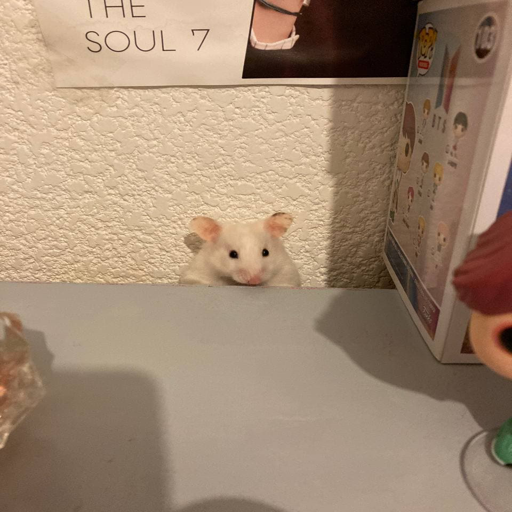

In [12]:
height = 512
width = 512

content_image_path = './base_image.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

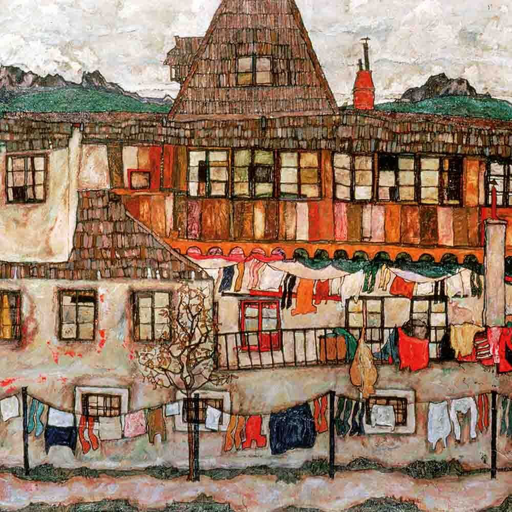

In [13]:
style_image_path = './style_image.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [14]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [15]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [16]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [17]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

The following Variables were used a Lambda layer's call (tf.concat), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32>
  <tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [19]:
model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [20]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <KerasTensor: shape=(1, 512, 512, 3) dtype=float32 (created by layer 'input_1')>,
 'tf.concat': <KerasTensor: shape=(3, 512, 512, 3) dtype=float32 (created by layer 'tf.concat')>,
 'block1_conv1': <KerasTensor: shape=(3, 512, 512, 64) dtype=float32 (created by layer 'block1_conv1')>,
 'block1_conv2': <KerasTensor: shape=(3, 512, 512, 64) dtype=float32 (created by layer 'block1_conv2')>,
 'block1_pool': <KerasTensor: shape=(3, 256, 256, 64) dtype=float32 (created by layer 'block1_pool')>,
 'block2_conv1': <KerasTensor: shape=(3, 256, 256, 128) dtype=float32 (created by layer 'block2_conv1')>,
 'block2_conv2': <KerasTensor: shape=(3, 256, 256, 128) dtype=float32 (created by layer 'block2_conv2')>,
 'block2_pool': <KerasTensor: shape=(3, 128, 128, 128) dtype=float32 (created by layer 'block2_pool')>,
 'block3_conv1': <KerasTensor: shape=(3, 128, 128, 256) dtype=float32 (created by layer 'block3_conv1')>,
 'block3_conv2': <KerasTensor: shape=(3, 128, 128, 256) dtype=float32 (cr

In [21]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [ ]:
def preprocess_image_nop():
    # Util function to open, resize and format pictures into appropriate tensors
    
    #base_image_path = keras.preprocessing.image.load_img("./base_image.jpg")
    
    img = keras.preprocessing.image.load_img(
        "./base_image.jpg", target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.preprocessing.image.load_img("./base_image.jpg")

#keras.utils.get_file("base_image.jpg")
style_reference_image_path = keras.utils.get_file(
    "EaG5URr.jpeg", "https://imgur.com/gallery/fTbmm"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = base_image_path.size#keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [22]:
loss = backend.variable(0.)

In [44]:
from tensorflow.python.framework.ops import disable_eager_execution

In [45]:
disable_eager_execution()

In [24]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

valor = content_weight * content_loss(content_image_features,
                                      combination_features)

#loss.assign(valor)
#loss += content_weight * content_loss(content_image_features,
#                                      combination_features)

In [25]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [27]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss.assign_add( (style_weight / len(feature_layers)) * sl)

TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [ ]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [ ]:
grads = backend.gradients(loss, combination_image)

In [ ]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

In [ ]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

4431872/4422102 [==============================] - 4s 1us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


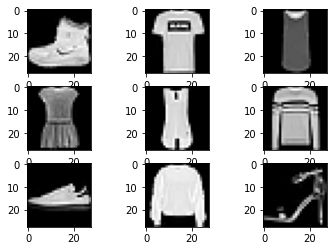

In [7]:
# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [9]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [12]:
class_names[y_train[23]]

'Sneaker'

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### An alternative is to use layers as arguments

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=10,
                    validation_data=(X_valid, y_valid))

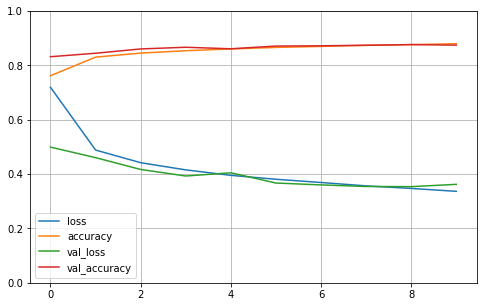

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3976 - accuracy: 0.8591


[0.3975924253463745, 0.8590999841690063]

In [35]:
X_new = X_test[25:31]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.87, 0.  , 0.1 , 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  , 0.28, 0.  , 0.7 , 0.  , 0.  , 0.  ],
       [0.8 , 0.  , 0.  , 0.14, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.8 ],
       [0.06, 0.  , 0.01, 0.58, 0.22, 0.  , 0.14, 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ]],
      dtype=float32)

In [36]:
y_pred = model.predict_classes(X_new)

np.array(class_names)[y_pred]

array(['Pullover', 'Shirt', 'T-shirt/top', 'Ankle boot', 'Dress', 'Bag'],
      dtype='<U11')

In [46]:
y_pred

array([2, 6, 0, 9, 3, 8])

In [38]:
testy[25:31]

array([4, 6, 0, 9, 3, 8], dtype=uint8)

In [40]:
np.array(class_names)[testy[25:31]]

array(['Coat', 'Shirt', 'T-shirt/top', 'Ankle boot', 'Dress', 'Bag'],
      dtype='<U11')

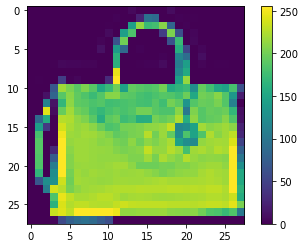

In [37]:
plt.figure()
plt.imshow(testX[30])
plt.colorbar()
plt.grid(False)
plt.show()

# Lets solve the HR dataset problem with a NN

In [10]:
hrdata = pd.read_csv('HR.csv')

In [11]:
hrdata.shape

(1470, 35)

In [12]:
hrdata.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [13]:
hrdata['Attrition'] = hrdata.Attrition.map({'Yes':1,
                                              'No':0})

In [14]:
hrdata.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [15]:
A = list(hrdata.columns) # List with all columns
B = list(hrdata.corr().columns) # List with only numeric columns
for x in B:
  A.remove(x) # Only the columns that are not numeric
A # the list of categorical variables that we need to transform to numbers

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [16]:
hrdata['BusinessTravel'] = hrdata.BusinessTravel.map({'Travel_Rarely':1, 'Travel_Frequently':2, 'Non-Travel':3})

hrdata['Department'] = hrdata.Department.map({'Research & Development':1, 'Sales':2, 'Human Resources':3})

hrdata['EducationField'] = hrdata.EducationField.map({'Life Sciences':1, 'Medical':2, 'Marketing':3, 
                                                      'Technical Degree':4, 'Other':5, 'Human Resources':6})

hrdata['Gender'] = hrdata.Gender.map({'Male':1, 'Female':2})

hrdata['JobRole'] = hrdata.JobRole.map({'Sales Executive':1, 'Research Scientist':2, 'Laboratory Technician':3, 
                                        'Manufacturing Director':4, 'Healthcare Representative':5, 'Manager':6, 
                                        'Sales Representative':7, 'Research Director':8, 'Human Resources':9})

hrdata['MaritalStatus'] = hrdata.MaritalStatus.map({'Married':1, 'Single':2, 'Divorced':3})

hrdata['OverTime'] = hrdata.OverTime.map({'No':1, 'Yes':2})
#hrdata['JobRole'] = hrdata.BusinessTravel.map({'Travel_Rarely':1, 'Travel_Frequently':2, 'Non-Travel':3})

In [17]:
for col in ['BusinessTravel', 'Department', 'EducationField', 
            'Gender','JobRole','MaritalStatus','OverTime']:
    hrdata[col] = hrdata[col].astype('category')

In [18]:
hrdata.drop(columns=['EmployeeCount','EmployeeNumber','JobLevel', 'Over18', 'StandardHours', 'TotalWorkingYears'], inplace=True)

In [106]:
hrdata.Attrition.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

In [139]:
df3=  hrdata[hrdata.Attrition==0].sample(1000).reset_index(drop=True)
df4=  hrdata[hrdata.Attrition == 1]
hrdata_train = pd.concat([df3 , df4 , df4] , axis=0).reset_index(drop=True)

In [140]:
#hrdata_train=hrdata
hrdata_train.sample()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
623,25,0,1,583,2,4,1,3,3,1,87,2,1,1,1,4256,18154,1,1,12,3,1,0,1,4,5,2,0,3


In [122]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [124]:
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 
            'Gender','JobRole','MaritalStatus','OverTime']

In [141]:
dummy = pd.get_dummies(hrdata_train[cat_cols], drop_first=True)

In [142]:
dummy.head(1)

,BusinessTravel_2,BusinessTravel_3,Department_2,Department_3,EducationField_2,EducationField_3,EducationField_4,EducationField_5,EducationField_6,Gender_2,JobRole_2,JobRole_3,JobRole_4,JobRole_5,JobRole_6,JobRole_7,JobRole_8,JobRole_9,MaritalStatus_2,MaritalStatus_3,OverTime_2
0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [143]:
hrdata_train_dum = pd.concat([hrdata_train, dummy], axis=1).drop(columns=cat_cols, axis=1)
hrdata_train_dum.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_2,BusinessTravel_3,Department_2,Department_3,EducationField_2,EducationField_3,EducationField_4,EducationField_5,EducationField_6,Gender_2,JobRole_2,JobRole_3,JobRole_4,JobRole_5,JobRole_6,JobRole_7,JobRole_8,JobRole_9,MaritalStatus_2,MaritalStatus_3,OverTime_2
0,27,0,205,10,3,4,98,2,4,5769,7100,1,11,3,4,0,3,3,6,2,4,4,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,41,0,642,1,3,4,76,3,4,2782,21412,3,22,4,1,1,3,3,5,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,39,0,1462,6,3,4,38,4,3,8237,4658,2,11,3,1,1,3,3,7,6,7,6,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,38,0,268,2,5,4,92,3,3,3057,20471,6,13,3,2,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,27,0,728,23,1,2,36,2,3,3540,7018,1,21,4,4,1,5,3,9,8,5,8,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [144]:
x = hrdata_train_dum.drop('Attrition',1) ### Drop before having the target variable
y = hrdata_train_dum['Attrition']

print(x.shape)
print(y.shape)

(1474, 42)
(1474,)


In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, 
                                                    random_state=2021, 
                                                    test_size=0.2,
                                                    stratify =y)

In [145]:
X_tr, x_test, y_tr, y_test = train_test_split(x, y,
        train_size=0.85,
        test_size=0.15,
        # random but same for all run
        random_state=2021,
        # keep same proportion of 'targets'
        stratify=y
    )

x_train, x_val, y_train, y_val = train_test_split(X_tr, y_tr,
        train_size=0.85,
        test_size=0.15,
        random_state=2021,
        stratify=y_tr
    )

In [64]:
accuracies =dict()
recall = dict()

In [62]:
# statistical learning
from sklearn.linear_model import LogisticRegression

# tree based methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# To measure performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cfm
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn import metrics

In [64]:
dt = DecisionTreeClassifier(ccp_alpha=9e-05, criterion='entropy', max_depth=16,
                       max_features=12, random_state=20210614) # hemos puesto los parametros encontrados en el grid search
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)

In [65]:
accuracies['Decision Tree Classifier'] = accuracy_score(y_pred, y_test)
recall['Decision Tree Classifier'] = metrics.recall_score(y_test,y_pred)

print('Accuracy of Decision Tree Classifier is: ', accuracy_score(y_test,y_pred))
print('Recall Score of Decision Tree Classifier is: ', metrics.recall_score(y_test, y_pred))

Accuracy of Decision Tree Classifier is:  0.7955555555555556
Recall Score of Decision Tree Classifier is:  0.9157894736842105


In [67]:
cfm(y_test, y_pred)

array([[92, 38],
       [ 8, 87]])

In [68]:
lgr = LogisticRegression(max_iter=10000,C=0.473, random_state=20210614, warm_start=True)
lgr.fit(x_train, y_train)

y_pred = lgr.predict(x_test)

accuracies['Logistic Regression'] = accuracy_score(y_test, y_pred)
recall['Logistic Regression'] = metrics.recall_score(y_test,y_pred)

print('Accuracy Score of Logistic Regression is: ', accuracy_score(y_test, y_pred))
print('Recall Score of Logistic Regression Model is: ', metrics.recall_score(y_test, y_pred))

Accuracy Score of Logistic Regression is:  0.7377777777777778
Recall Score of Logistic Regression Model is:  0.6842105263157895


In [69]:
cfm(y_test, y_pred)

array([[101,  29],
       [ 30,  65]])

In [70]:
rf = RandomForestClassifier(max_depth=12, max_features=11, n_estimators=180,
                       random_state=20210614, n_jobs=-1
                           )

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)


accuracies['Random Forest Classifier'] = accuracy_score( y_test, y_pred)
recall['Random Forest Classifier'] = metrics.recall_score(y_test,y_pred)


print('Accuracy Score of Random Forest Classifier is: ', accuracy_score(y_test, y_pred))
print('Recall Score of Random Forest Classifier Model is: ', metrics.recall_score(y_test, y_pred))

Accuracy Score of Random Forest Classifier is:  0.8977777777777778
Recall Score of Random Forest Classifier Model is:  0.9157894736842105


In [71]:
cfm(y_test, y_pred)

array([[115,  15],
       [  8,  87]])

In [72]:
recall = pd.DataFrame(list(recall.items()), columns=['Model', 'Recall Score'])
accuracies = pd.DataFrame(list(accuracies.items()),columns=['Model','Accuracy Score'])

In [73]:
accuracies_df = pd.merge(accuracies, recall, on='Model')
accuracies_df

,Model,Accuracy Score,Recall Score
0,Decision Tree Classifier,0.795556,0.915789
1,Logistic Regression,0.737778,0.684211
2,Random Forest Classifier,0.897778,0.915789


### We use a Neural Network instead of a tree

In [121]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
scaler = StandardScaler()
enc = OneHotEncoder(handle_unknown='ignore')

In [146]:
X_train_sc = scaler.fit_transform(x_train)
X_val_sc = scaler.transform(x_val)
X_test_sc = scaler.transform(x_test)

In [147]:
model = keras.models.Sequential([
    keras.layers.Dense(84, activation="relu"),
    keras.layers.Dense(56, activation="elu"),
    keras.layers.Dense(14, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [148]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              #optimizer="rmsprop",
              metrics=["accuracy"])

In [149]:
history = model.fit(X_train_sc, y_train, 
                    epochs=100,
                    shuffle=True,
                    #validation_split=0.15,
                    validation_data=(X_val_sc, y_val),
                    verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=15, 
                                             min_delta=0.0001,
                                             restore_best_weights=True)]
                   )

In [58]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 1,421
Trainable params: 1,421
Non-trainable params: 0
_________________________________________________________________


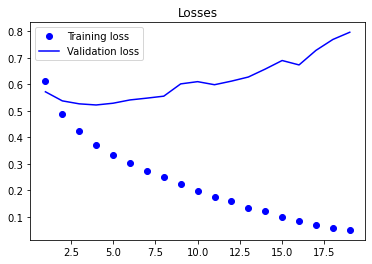

In [150]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epos = range(1, len(loss) + 1)

plt.plot(epos, loss, 'bo', label='Training loss')
plt.plot(epos, val_loss, 'b', label='Validation loss')
plt.title('Losses')
plt.legend()
plt.show()

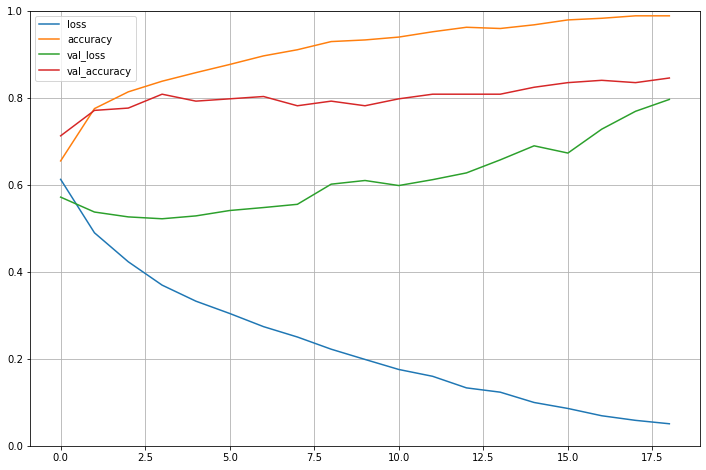

In [151]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [426]:
#model.predict(x_test)

In [152]:
# We can change the scaled variables
y_pred = (model.predict(X_test_sc) > 0.41).astype("int32")#


accuracies['NN-Multilayer perceptron'] = accuracy_score( y_test, y_pred)
recall['Democratic Classifier'] = metrics.recall_score(y_test,y_pred)


print('Accuracy Score of NN-Multilayer perceptron is: ', accuracy_score(y_test, y_pred))
print('Recall Score of NN-Multilayer perceptron is: ', metrics.recall_score(y_test, y_pred))

Accuracy Score of NN-Multilayer perceptron is:  0.8198198198198198
Recall Score of NN-Multilayer perceptron is:  0.6338028169014085


In [153]:
cfm(y_test, y_pred)

array([[137,  14],
       [ 26,  45]])

In [154]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       151
           1       0.76      0.63      0.69        71

    accuracy                           0.82       222
   macro avg       0.80      0.77      0.78       222
weighted avg       0.82      0.82      0.81       222

